dans la plupart des articles que nous avons vu CRF-LSTM pour modéliser la structure séquentielle de nos phrases. Nous avons utilisé le LSTM au niveau des mots et appliqué des embeddings de mots. Bien que cette approche soit simple et donne souvent de bons résultats, il existe des lacunes potentielles. Si nous n’avons pas vu un mot à une heure de prédiction, nous devons l’encoder comme inconnu et en déduire sa signification par les mots qui l’entourent. Souvent, le mot suffixe ou préfixe contient beaucoup d'informations sur la signification du mot. L'utilisation de ces informations est très importante si vous traitez avec des textes contenant beaucoup de mots rares et que vous vous attendez à beaucoup de mots inconnus au moment de l'inférence. Par exemple lorsque vous travaillez avec des textes médicaux.

Pour encoder les informations au niveau des caractères, nous utiliserons des imbrications de caractères et un LSTM pour encoder chaque mot en un vecteur. Nous pouvons utiliser essentiellement tout ce qui produit un seul vecteur pour une séquence de caractères représentant un mot. Vous pouvez également utiliser une architecture de pooling maximal ou un CNN ou tout ce qui fonctionne pour vous. Ensuite, nous transmettons le vecteur à un autre LSTM avec l'incorporation du mot appris.

Nous commençons par charger les données.

In [54]:
import pandas as pd
import numpy as np

data = pd.read_csv("dataAnnotated.csv", encoding="utf-8")

In [55]:
data = data.fillna(method="ffill")

In [56]:
data.head(60)

,Line#,Word,Tag
0,Line0,De,NoTag
1,Line0,tous,NoTag
2,Line0,les,NoTag
3,Line0,poëtes,NoTag
4,Line0,de‧l',NoTag
5,Line0,"Antiquité,",NoTag
6,Line0,Pindare,OEUVRES
7,Line1,est,NoTag
8,Line1,certainement,NoTag
9,Line1,aujourd',NoTag


In [57]:
words = list(set(data["Word"].values))
n_words = len(words); n_words

35708

In [58]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags

7

Nous avons donc 47959 phrases contenant 35178 mots différents avec 17 balises différentes. Nous utilisons la classe SentenceGetter du dernier message pour récupérer des phrases avec leurs étiquettes.

In [59]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w,t) for w,t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Line#").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Line{}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

Voici à quoi ressemble une phrase maintenant.

In [60]:
getter = SentenceGetter(data) #obtenir toutes les phrases.
sen = getter.get_next()
print(sen)

[('est', 'NoTag'), ('certainement', 'NoTag'), ("aujourd'", 'NoTag'), ('hui', 'NoTag'), ('le', 'NoTag'), ('plus', 'NoTag'), ('éloigné', 'NoTag'), ('de', 'NoTag'), ('nous.', 'NoTag'), ('Plus', 'NoTag'), ("qu'", 'NoTag'), ('aucun', 'NoTag'), ('des', 'NoTag'), ('grands', 'NoTag'), ('écrivains,', 'NoTag'), ('il', 'NoTag'), ('appartient', 'NoTag'), ('à', 'NoTag'), ('son', 'NoTag'), ('temps', 'NoTag'), ('et', 'NoTag'), ('ne', 'NoTag'), ('le', 'NoTag'), ('dépasse', 'NoTag'), ('guère.', 'NoTag'), ('Il', 'NoTag'), ('incarne', 'NoTag'), ('les', 'NoTag'), ('idées,', 'NoTag'), ('les', 'NoTag'), ('sentiments', 'NoTag'), ('de', 'NoTag'), ('son', 'NoTag'), ('époque', 'NoTag'), ('sans', 'NoTag'), ('jamais', 'NoTag'), ('les', 'NoTag'), ('dominer', 'NoTag'), ('-', 'NoTag'), ('autrement', 'NoTag'), ('que', 'NoTag'), ('par', 'NoTag'), ('la', 'NoTag'), ('beauté', 'NoTag'), ('de', 'NoTag'), ('son', 'NoTag'), ('style.', 'NoTag'), ('Que', 'NoTag'), ('dis-je?', 'NoTag'), ('Ce', 'NoTag'), ('ne', 'NoTag'), ('sont

Maintenant, nous introduisons des dictionnaires de mots et de balises.

In [61]:
getter = SentenceGetter(data)
sentences = getter.sentences
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [62]:
max_len = 75
max_len_char = 20
n_tags+=20
n_words+=20
n_chars+=20

Maintenant, nous mappons les phrases à une séquence de nombres, puis nous remplissons la séquence. Notez que nous avons augmenté l'index des mots de un pour utiliser zéro comme valeur de remplissage. Ceci est fait parce que nous voulons utiliser le paramètre mask_zero du calque d'intégration pour ignorer les entrées avec la valeur zéro.

et Nous devons aussi générer un dictionnaire pour les caractères que nous voulons utiliser et créer la séquence de caractères pour chaque jeton. Notez que nous, plutôt arbitraire, fixons max_len_char à 10. Nous pourrions également utiliser des séquences plus longues ou plus courtes. On pourrait même utiliser deux séquences, une avec les cinq premiers caractères et une avec les cinq derniers caractères.

In [63]:
from keras.preprocessing.sequence import pad_sequences
X_word = [[word2idx[w[0]] for w in s] for s in sentences]
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0
X_char = []
for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

125


Et nous devons faire de même pour votre séquence de balises.

In [64]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')


séparer les données en train et ensemble de test.

In [65]:
from sklearn.model_selection import train_test_split
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=2018)

In [66]:
from keras.models import Model,Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D

In [67]:
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=20,
                     input_length=max_len, mask_zero=True)(word_in)

char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                           input_length=max_len_char, mask_zero=True))(char_in)
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char) #LSTM des characteres 

x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.6))(x) #Bi-LSTM des mots 
out = TimeDistributed(Dense(n_tags + 1, activation="sigmoid"))(main_lstm)

model = Model([word_in, char_in], out)


Maintenant, nous pouvons compiler le modèle comme toujours et regarder le résumé.

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 75, 20)]     0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 75)]         0                                            
__________________________________________________________________________________________________
time_distributed_6 (TimeDistrib (None, 75, 20, 10)   1270        input_6[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 75, 20)       714600      input_5[0][0]                    
_______________________________________________________________________________________

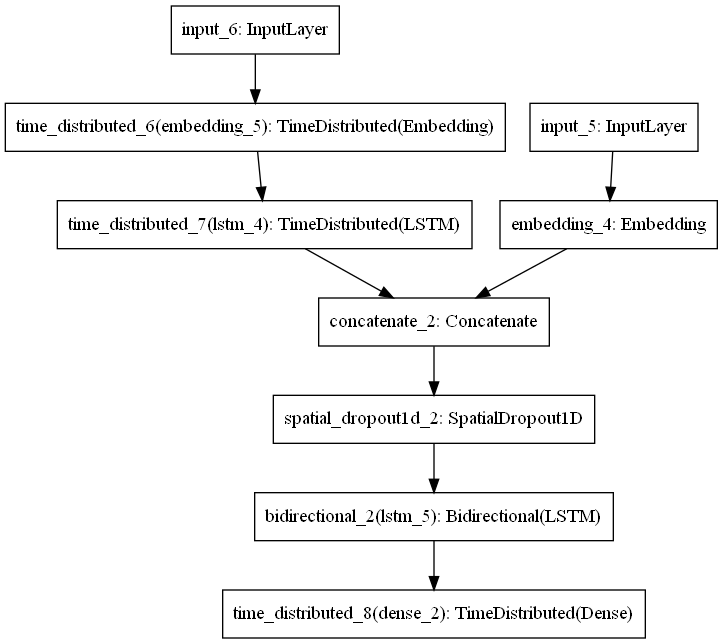

In [68]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
model.summary()
from keras.utils import plot_model
plot_model(model)

In [69]:
history2 = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=10, validation_split=0.1, verbose=1)


Epoch 1/10
255/255 [==============================] - 127s 499ms/step - loss: 0.2078 - acc: 0.9605 - val_loss: 0.0426 - val_acc: 0.9668
Epoch 2/10
255/255 [==============================] - 89s 350ms/step - loss: 0.0408 - acc: 0.9660 - val_loss: 0.0364 - val_acc: 0.9668
Epoch 3/10
255/255 [==============================] - 126s 495ms/step - loss: 0.0359 - acc: 0.9660 - val_loss: 0.0320 - val_acc: 0.9668
Epoch 4/10
255/255 [==============================] - 112s 441ms/step - loss: 0.0302 - acc: 0.9660 - val_loss: 0.0269 - val_acc: 0.9668
Epoch 5/10
255/255 [==============================] - 112s 440ms/step - loss: 0.0243 - acc: 0.9660 - val_loss: 0.0226 - val_acc: 0.9668
Epoch 6/10
255/255 [==============================] - 145s 570ms/step - loss: 0.0201 - acc: 0.9661 - val_loss: 0.0209 - val_acc: 0.9668
Epoch 7/10
255/255 [==============================] - 126s 495ms/step - loss: 0.0178 - acc: 0.9663 - val_loss: 0.0201 - val_acc: 0.9668
Epoch 8/10
255/255 [=============================

In [70]:
hist2 = pd.DataFrame(history2.history)

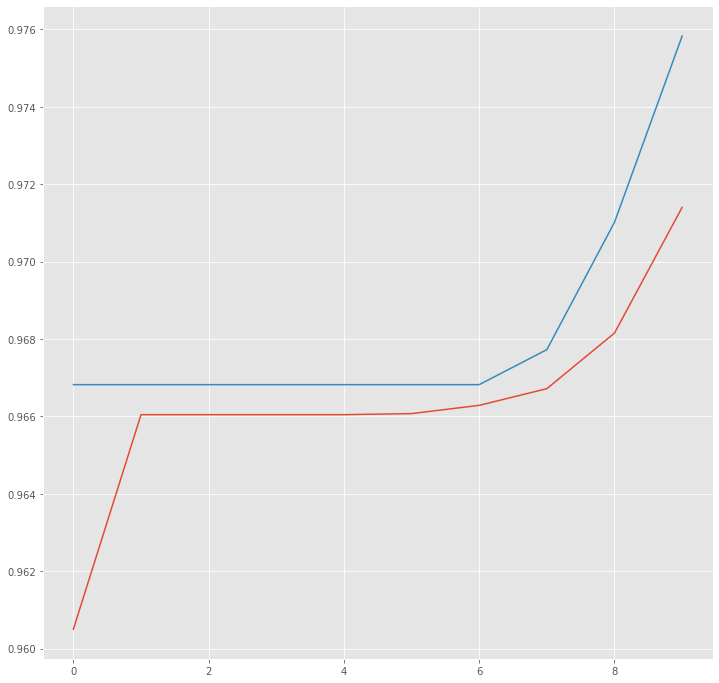

In [71]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist2["acc"])
plt.plot(hist2["val_acc"])
plt.show()

In [72]:
y_pred = model.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char))])

Prédictions sur les données de test :

In [73]:
for i in range(1000) : 
    p = np.argmax(y_pred[i], axis=-1)
    print(
        "{:15}||{:5}||{}".format("Word", "True", "Pred"))
    print(30 * "=")
    for w, t, pred in zip(X_word_te[i], y_te[i], p):
        if w != 0:
                print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))

Word           ||True ||Pred
sont           : NoTag NoTag
particulièrement: NoTag NoTag
denses         : NoTag NoTag
et             : NoTag NoTag
bien           : NoTag NoTag
écrites.       : NoTag NoTag
Elles          : NoTag NoTag
offrent        : NoTag NoTag
de             : NoTag NoTag
plus           : NoTag NoTag
l'             : NoTag NoTag
avantage       : NoTag NoTag
d'             : NoTag NoTag
avoir          : NoTag NoTag
une            : NoTag NoTag
signification  : NoTag NoTag
générale.      : NoTag NoTag
Je             : NoTag NoTag
veux           : NoTag NoTag
dire           : NoTag NoTag
par            : NoTag NoTag
là             : NoTag NoTag
qu'            : NoTag NoTag
elles          : NoTag NoTag
offrent        : NoTag NoTag
des            : NoTag NoTag
images         : NoTag NoTag
de‧la          : NoTag NoTag
vie            : NoTag NoTag
qui            : NoTag NoTag
ont            : NoTag NoTag
un             : NoTag NoTag
sens           : NoTag NoTag
et           

durable        : NoTag NoTag
menace         : NoTag NoTag
Antinoüs       : PERSONNAGES NoTag
Word           ||True ||Pred
ne             : NoTag NoTag
raconte        : NoTag NoTag
que            : NoTag NoTag
ce             : NoTag NoTag
qu'            : NoTag NoTag
elle           : NoTag NoTag
n'             : NoTag NoTag
a              : NoTag NoTag
pas            : NoTag NoTag
connu :        : NoTag NoTag
la             : NoTag NoTag
jeunesse.      : NoTag NoTag
de             : NoTag NoTag
son            : NoTag NoTag
père,          : NoTag NoTag
marquée        : NoTag NoTag
par            : NoTag NoTag
tant           : NoTag NoTag
d'             : NoTag NoTag
aventures.     : NoTag NoTag
Les            : NoTag NoTag
unes           : NoTag NoTag
viennent       : NoTag NoTag
du             : NoTag NoTag
sort,          : NoTag NoTag
les            : NoTag NoTag
autres         : NoTag NoTag
d'             : NoTag NoTag
un             : NoTag NoTag
caractère      : NoTag NoTag
qui     

de‧la          : NoTag NoTag
langue.        : NoTag NoTag
Il             : NoTag NoTag
y              : NoTag NoTag
a              : NoTag NoTag
en             : NoTag NoTag
France         : LIEUX NoTag
Word           ||True ||Pred
Enfermée       : NoTag NoTag
dans           : NoTag NoTag
son            : NoTag NoTag
île,           : NoTag NoTag
recluse        : NoTag NoTag
dans           : NoTag NoTag
ses            : NoTag NoTag
personnages,   : NoTag NoTag
Hadrien        : PERSONNAGES NoTag
Word           ||True ||Pred
à              : NoTag NoTag
celui          : NoTag NoTag
d'             : NoTag NoTag
Hadrien,       : NoTag NoTag
et             : NoTag NoTag
d'             : NoTag NoTag
Antinoüs       : PERSONNAGES NoTag
Word           ||True ||Pred
,              : NoTag NoTag
fait           : NoTag NoTag
souvent        : NoTag NoTag
référence      : NoTag NoTag
aux            : NoTag NoTag
œuvres         : NoTag NoTag
allemandes     : NoTag NoTag
et             : NoTag NoTag
ho

quelques       : NoTag NoTag
liaisons       : NoTag NoTag
avec           : NoTag NoTag
d'             : NoTag NoTag
aimables       : NoTag NoTag
personnes      : NoTag NoTag
[              : NoTag NoTag
]              : NoTag NoTag
qui            : NoTag NoTag
l'             : NoTag NoTag
enchanteront   : NoTag NoTag
jusqu'         : NoTag NoTag
au             : NoTag NoTag
seuil          : NoTag NoTag
de‧la          : NoTag NoTag
vieillesse ;   : NoTag NoTag
le             : NoTag NoTag
jeu,           : NoTag NoTag
assagi,        : NoTag NoTag
prudent,       : NoTag NoTag
devenu         : NoTag NoTag
banal          : NoTag NoTag
et             : NoTag NoTag
méthodique     : NoTag NoTag
comme          : NoTag NoTag
tous           : NoTag NoTag
les            : NoTag NoTag
vieux          : NoTag NoTag
vices ;        : NoTag NoTag
l'             : NoTag NoTag
automobilisme, : NoTag NoTag
art,           : NoTag NoTag
science,       : NoTag NoTag
Word           ||True ||Pred
 :            

prochain.      : NoTag NoTag
Le             : NoTag NoTag
deuxième       : NoTag NoTag
volume         : NoTag NoTag
de             : NoTag NoTag
ses            : NoTag NoTag
œuvres         : NoTag NoTag
théâtrales     : NoTag NoTag
rassemble      : NoTag NoTag
trois          : NoTag NoTag
autres         : NoTag NoTag
pièces         : NoTag NoTag
inspirées      : NoTag NoTag
cette          : NoTag NoTag
fois           : NoTag NoTag
par            : NoTag NoTag
la             : NoTag NoTag
mythologie     : NoTag NoTag
grecque        : NoTag NoTag
où             : NoTag NoTag
Yourcenar      : NoTag NoTag
donne          : NoTag NoTag
sa             : NoTag NoTag
propre         : NoTag NoTag
version        : NoTag NoTag
des            : NoTag NoTag
légendes       : NoTag NoTag
et             : NoTag NoTag
mythes         : NoTag NoTag
de‧l'          : NoTag NoTag
Antiquité.     : NoTag NoTag
Word           ||True ||Pred
de             : NoTag NoTag
Bésus          : NoTag NoTag
Thomas Sommery

Word           ||True ||Pred
,              : NoTag NoTag
Caimien        : NoTag NoTag
ou             : NoTag NoTag
Lu Dame de Pique: OEUVRES NoTag
.              : NoTag NoTag
Word           ||True ||Pred
t              : NoTag NoTag
aimée,         : NoTag NoTag
sa             : NoTag NoTag
culture        : NoTag NoTag
et             : NoTag NoTag
son            : NoTag NoTag
héritage       : NoTag NoTag
ne             : NoTag NoTag
seront         : NoTag NoTag
plus           : NoTag NoTag
perçus         : NoTag NoTag
comme          : NoTag NoTag
le             : NoTag NoTag
trésor         : NoTag NoTag
intime         : NoTag NoTag
d'             : NoTag NoTag
une            : NoTag NoTag
conscience     : NoTag NoTag
individuelle,  : NoTag NoTag
mais           : NoTag NoTag
comme          : NoTag NoTag
appel          : NoTag NoTag
profond,       : NoTag NoTag
originel       : NoTag NoTag
du             : NoTag NoTag
destin.        : NoTag NoTag
Pendant        : NoTag NoTag
cette      

Word           ||True ||Pred
où             : NoTag NoTag
je             : NoTag NoTag
tente          : NoTag NoTag
un             : NoTag NoTag
rapprochement  : NoTag NoTag
du             : NoTag NoTag
mystère        : NoTag NoTag
grec           : NoTag NoTag
et             : NoTag NoTag
du             : NoTag NoTag
mystère        : NoTag NoTag
chrétien.      : NoTag NoTag
J'             : NoTag NoTag
ai             : NoTag NoTag
aussi          : NoTag NoTag
fait           : NoTag NoTag
des            : NoTag NoTag
pièces         : NoTag NoTag
de             : NoTag NoTag
théâtre        : NoTag NoTag
dont           : NoTag NoTag
une :          : NoTag NoTag
Electre        : OEUVRES NoTag
Word           ||True ||Pred
,              : NoTag NoTag
Stanislas      : PERSONNAGES NoTag
Word           ||True ||Pred
d'             : NoTag NoTag
Hadrien,       : NoTag NoTag
qu'            : NoTag NoTag
elle           : NoTag NoTag
atteignit      : NoTag NoTag
le             : NoTag NoTag
grand 

premier        : NoTag NoTag
caboulot       : NoTag NoTag
venu           : NoTag NoTag
où             : NoTag NoTag
le             : NoTag NoTag
sert           : NoTag NoTag
une            : NoTag NoTag
rousse         : NoTag NoTag
flamboyante,   : NoTag NoTag
et             : NoTag NoTag
qui            : NoTag NoTag
informe        : NoTag NoTag
sur-le-champ   : NoTag NoTag
sa             : NoTag NoTag
famille        : NoTag NoTag
qu'            : NoTag NoTag
« en           : NoTag NoTag
France         : NoTag NoTag
toutes         : NoTag NoTag
les            : NoTag NoTag
femmes         : NoTag NoTag
sont           : NoTag NoTag
rousses » !    : NoTag NoTag
Dans           : NoTag NoTag
l'             : NoTag NoTag
esquisse       : NoTag NoTag
qui            : NoTag NoTag
suit           : NoTag NoTag
on             : NoTag NoTag
reconnaîtra    : NoTag NoTag
les            : NoTag NoTag
étendues       : NoTag NoTag
désolées       : NoTag NoTag
de‧l'          : NoTag NoTag
Ontario       

en             : NoTag NoTag
bois,          : NoTag NoTag
elle           : NoTag NoTag
remonte        : NoTag NoTag
aussitôt       : NoTag NoTag
par            : NoTag NoTag
la             : NoTag NoTag
pensée         : NoTag NoTag
à              : NoTag NoTag
l'             : NoTag NoTag
ouvrier        : NoTag NoTag
qui            : NoTag NoTag
l'             : NoTag NoTag
a              : NoTag NoTag
taillée,       : NoTag NoTag
à              : NoTag NoTag
Word           ||True ||Pred
,              : NoTag NoTag
c'             : NoTag NoTag
est            : NoTag NoTag
celui          : NoTag NoTag
de‧la          : NoTag NoTag
pensée         : NoTag NoTag
critique       : NoTag NoTag
que            : NoTag NoTag
Marguerite     : NoTag NoTag
Yourcenar      : NoTag NoTag
a              : NoTag NoTag
voulu          : NoTag NoTag
exprimer3 ».   : NoTag NoTag
Dans           : NoTag NoTag
Souvenirs      : NoTag NoTag
Pieux          : NoTag NoTag
et             : NoTag NoTag
Archives      

montre         : NoTag NoTag
des            : NoTag NoTag
photographies  : NoTag NoTag
qui            : NoTag NoTag
rappellent     : NoTag NoTag
les            : NoTag NoTag
rives          : NoTag NoTag
du             : NoTag NoTag
Léman          : LIEUX NoTag
Word           ||True ||Pred
C'             : NoTag NoTag
est            : NoTag NoTag
sa             : NoTag NoTag
forme          : NoTag NoTag
particulière   : NoTag NoTag
de             : NoTag NoTag
grandeur,      : NoTag NoTag
du             : NoTag NoTag
reste,         : NoTag NoTag
mais           : NoTag NoTag
ce             : NoTag NoTag
n'             : NoTag NoTag
est            : NoTag NoTag
pas            : NoTag NoTag
celle          : NoTag NoTag
qui            : NoTag NoTag
m'             : NoTag NoTag
est            : NoTag NoTag
particulièrement: NoTag NoTag
chère.         : NoTag NoTag
Je             : NoTag NoTag
ne             : NoTag NoTag
suis           : NoTag NoTag
pas            : NoTag NoTag
sûre         

fort           : NoTag NoTag
mal,           : NoTag NoTag
transcrit      : NoTag NoTag
au             : NoTag NoTag
présent        : NoTag NoTag
un             : NoTag NoTag
texte          : NoTag NoTag
écrit,         : NoTag NoTag
pensé          : NoTag NoTag
à              : NoTag NoTag
l'             : NoTag NoTag
imparfait      : NoTag NoTag
Virginia Woolf : AUTHORS AUTHORS
Word           ||True ||Pred
une            : NoTag NoTag
vie            : NoTag NoTag
d'             : NoTag NoTag
écriture,      : NoTag NoTag
remarquable    : NoTag NoTag
cheminement    : NoTag NoTag
dans           : NoTag NoTag
l'             : NoTag NoTag
œuvre          : NoTag NoTag
et             : NoTag NoTag
le             : NoTag NoTag
siècle         : NoTag NoTag
sans           : NoTag NoTag
que            : NoTag NoTag
l'             : NoTag NoTag
intimité       : NoTag NoTag
soit           : NoTag NoTag
lésée.         : NoTag NoTag
L'             : NoTag NoTag
écrivain       : NoTag NoTag
s'        

d'             : NoTag NoTag
illusions      : NoTag NoTag
sur            : NoTag NoTag
son            : NoTag NoTag
libre          : NoTag NoTag
arbitre        : NoTag NoTag
de             : NoTag NoTag
poète.         : NoTag NoTag
Il             : NoTag NoTag
sait           : NoTag NoTag
que            : NoTag NoTag
le             : NoTag NoTag
seul           : NoTag NoTag
plaisir        : NoTag NoTag
dont           : NoTag NoTag
il             : NoTag NoTag
soit           : NoTag NoTag
capable        : NoTag NoTag
est            : NoTag NoTag
d'             : NoTag NoTag
ordre          : NoTag NoTag
esthétique :   : NoTag NoTag
même           : NoTag NoTag
s'             : NoTag NoTag
il             : NoTag NoTag
rencontre      : NoTag NoTag
chez           : NoTag NoTag
un             : NoTag NoTag
partenaire     : NoTag NoTag
le             : NoTag NoTag
corps          : NoTag NoTag
qui            : NoTag NoTag
lui            : NoTag NoTag
convient,      : NoTag NoTag
il            

astiqués       : NoTag NoTag
et             : NoTag NoTag
sa             : NoTag NoTag
machine        : NoTag NoTag
à              : NoTag NoTag
écrire.        : NoTag NoTag
On             : NoTag NoTag
ne             : NoTag NoTag
peut           : NoTag NoTag
rêver          : NoTag NoTag
de             : NoTag NoTag
plus           : NoTag NoTag
de             : NoTag NoTag
solitude,      : NoTag NoTag
de             : NoTag NoTag
dépaysement    : NoTag NoTag
plus           : NoTag NoTag
total          : NoTag NoTag
pour           : NoTag NoTag
cette          : NoTag NoTag
vieille        : NoTag NoTag
dame           : NoTag NoTag
si             : NoTag NoTag
elle           : NoTag NoTag
venait         : NoTag NoTag
d'             : NoTag NoTag
être           : NoTag NoTag
reçue          : NoTag NoTag
sous           : NoTag NoTag
la             : NoTag NoTag
Coupole        : INSTITUTIONS LIEUX
.              : NoTag NoTag
Word           ||True ||Pred
,              : NoTag NoTag
Et     

en             : NoTag NoTag
1961.          : NoTag NoTag
Ils            : NoTag NoTag
vivaient       : NoTag NoTag
l'             : NoTag NoTag
été            : NoTag NoTag
et             : NoTag NoTag
l'             : NoTag NoTag
automne        : NoTag NoTag
accrochés      : NoTag NoTag
aux            : NoTag NoTag
bords          : NoTag NoTag
sauvages       : NoTag NoTag
de‧l'          : NoTag NoTag
île            : NoTag NoTag
de             : NoTag NoTag
Sutton         : LIEUX NoTag
Word           ||True ||Pred
ende           : NoTag NoTag
des            : NoTag NoTag
quarante-sept  : NoTag NoTag
ronin,         : NoTag NoTag
le             : NoTag NoTag
théâtre        : NoTag NoTag
traditionnel.  : NoTag NoTag
Elle           : NoTag NoTag
s'             : NoTag NoTag
attache        : NoTag NoTag
également      : NoTag NoTag
à              : NoTag NoTag
la             : NoTag NoTag
vie            : NoTag NoTag
quotidienne    : NoTag NoTag
de             : NoTag NoTag
ces           

évoque         : NoTag NoTag
sa             : NoTag NoTag
croisière      : NoTag NoTag
en             : NoTag NoTag
Alaska         : LIEUX NoTag
Word           ||True ||Pred
Il             : NoTag NoTag
y              : NoTag NoTag
a              : NoTag NoTag
un             : NoTag NoTag
écho           : NoTag NoTag
de‧la          : NoTag NoTag
rencontre      : NoTag NoTag
avec           : NoTag NoTag
Cavafy         : AUTHORS AUTHORS
Word           ||True ||Pred
tire           : NoTag NoTag
sa             : NoTag NoTag
profonde       : NoTag NoTag
résonance      : NoTag NoTag
et             : NoTag NoTag
tout           : NoTag NoTag
ensemble,      : NoTag NoTag
sa             : NoTag NoTag
fièvre         : NoTag NoTag
et             : NoTag NoTag
sa             : NoTag NoTag
sérénité       : NoTag NoTag
Marguerite Yourcenar: AUTHORS AUTHORS
Word           ||True ||Pred
.              : NoTag NoTag
Un             : NoTag NoTag
très           : NoTag NoTag
beau           : NoTag NoTag
t

Marguerite Yourcenar: AUTHORS AUTHORS
passe          : NoTag NoTag
ensuite,       : NoTag NoTag
si             : NoTag NoTag
la             : NoTag NoTag
connaissance   : NoTag NoTag
des            : NoTag NoTag
textes         : NoTag NoTag
est            : NoTag NoTag
partout        : NoTag NoTag
présente,      : NoTag NoTag
partout        : NoTag NoTag
aussi          : NoTag NoTag
elle           : NoTag NoTag
reste          : NoTag NoTag
cachée.        : NoTag NoTag
La             : NoTag NoTag
force          : NoTag NoTag
de             : NoTag NoTag
son            : NoTag NoTag
imagination,   : NoTag NoTag
elle           : NoTag NoTag
la             : NoTag NoTag
doit           : NoTag NoTag
à              : NoTag NoTag
sa             : NoTag NoTag
faculté        : NoTag NoTag
de             : NoTag NoTag
percer         : NoTag NoTag
tout           : NoTag NoTag
droit          : NoTag NoTag
et             : NoTag NoTag
d'             : NoTag NoTag
un             : NoTag NoTag
seul 

Word           ||True ||Pred
d'             : NoTag NoTag
Hadrien,       : NoTag NoTag
L'             : NoTag NoTag
Œuvre          : NoTag NoTag
au             : NoTag NoTag
noir           : NoTag NoTag
ont            : NoTag NoTag
indiscutablement: NoTag NoTag
placé          : NoTag NoTag
l'             : NoTag NoTag
écrivain       : NoTag NoTag
au             : NoTag NoTag
niveau         : NoTag NoTag
des            : NoTag NoTag
plus           : NoTag NoTag
grands.        : NoTag NoTag
Pourtant,      : NoTag NoTag
il             : NoTag NoTag
me             : NoTag NoTag
semble         : NoTag NoTag
qu'            : NoTag NoTag
elle           : NoTag NoTag
vient          : NoTag NoTag
encore         : NoTag NoTag
de             : NoTag NoTag
se             : NoTag NoTag
surpasser      : NoTag NoTag
en             : NoTag NoTag
nous           : NoTag NoTag
donnant        : NoTag NoTag
ces            : NoTag NoTag
Archives       : NoTag NoTag
du             : NoTag NoTag
Nord37,      

Word           ||True ||Pred
,              : NoTag NoTag
la             : NoTag NoTag
musique        : NoTag NoTag
selon          : NoTag NoTag
Proust         : AUTHORS NoTag
Word           ||True ||Pred
pour           : NoTag NoTag
Athènes        : LIEUX NoTag
.              : NoTag NoTag
Il             : NoTag NoTag
avait          : NoTag NoTag
vingt          : NoTag NoTag
ans.           : NoTag NoTag
Word           ||True ||Pred
Jean Prasteau  : CRITIQUES OEUVRES
.              : NoTag NoTag
Word           ||True ||Pred
title :        : NoTag NoTag
Feux           : OEUVRES NoTag
Word           ||True ||Pred
et             : NoTag NoTag
déjà,          : NoTag NoTag
dans           : NoTag NoTag
les            : NoTag NoTag
incendies      : NoTag NoTag
allumés        : NoTag NoTag
par            : NoTag NoTag
César,         : NoTag NoTag
se             : NoTag NoTag
dessinent      : NoTag NoTag
les            : NoTag NoTag
villages       : NoTag NoTag
dont           : NoTag NoTag
la  

de             : NoTag NoTag
pleine         : NoTag NoTag
terre,         : NoTag NoTag
et             : NoTag NoTag
qui            : NoTag NoTag
n'             : NoTag NoTag
est            : NoTag NoTag
déjà           : NoTag NoTag
plus           : NoTag NoTag
à              : NoTag NoTag
l'             : NoTag NoTag
état           : NoTag NoTag
sauvage.       : NoTag NoTag
Et             : NoTag NoTag
sur            : NoTag NoTag
le             : NoTag NoTag
seul           : NoTag NoTag
plan           : NoTag NoTag
littéraire,    : NoTag NoTag
Word           ||True ||Pred
céleste        : NoTag NoTag
et             : NoTag NoTag
celle          : NoTag NoTag
des            : NoTag NoTag
carrefours     : NoTag NoTag
est            : NoTag NoTag
devenue        : NoTag NoTag
l'             : NoTag NoTag
Aphrodite      : PERSONNAGES NoTag
des            : NoTag NoTag
mers.          : NoTag NoTag
Word           ||True ||Pred
Pour           : NoTag NoTag
l'             : NoTag NoTag
esprit  

en             : NoTag NoTag
lassitude,     : NoTag NoTag
en             : NoTag NoTag
impatience.    : NoTag NoTag
Durant         : NoTag NoTag
près           : NoTag NoTag
de             : NoTag NoTag
Word           ||True ||Pred
d'             : NoTag NoTag
Hadrien        : NoTag NoTag
a              : NoTag NoTag
fait           : NoTag NoTag
interpréter    : NoTag NoTag
mon            : NoTag NoTag
œuvre          : NoTag NoTag
dans           : NoTag NoTag
une            : NoTag NoTag
direction      : NoTag NoTag
qui            : NoTag NoTag
n'             : NoTag NoTag
est            : NoTag NoTag
pas            : NoTag NoTag
la             : NoTag NoTag
sienne.        : NoTag NoTag
On             : NoTag NoTag
a              : NoTag NoTag
vu             : NoTag NoTag
dans           : NoTag NoTag
ce             : NoTag NoTag
livre          : NoTag NoTag
un             : NoTag NoTag
ouvrage        : NoTag NoTag
d'             : NoTag NoTag
érudition      : NoTag NoTag
sur           

Bayle          : NoTag NoTag
dans           : NoTag NoTag
son            : NoTag NoTag
Dictionnaire   : NoTag NoTag
au             : NoTag NoTag
mot            : NoTag NoTag
Hadrien        : NoTag NoTag
pour           : NoTag NoTag
voir           : NoTag NoTag
remettre       : NoTag NoTag
les.           : NoTag NoTag
choses         : NoTag NoTag
au             : NoTag NoTag
point          : NoTag NoTag
avec           : NoTag NoTag
toute          : NoTag NoTag
la             : NoTag NoTag
drôlerie       : NoTag NoTag
dont           : NoTag NoTag
peuvent        : NoTag NoTag
s'             : NoTag NoTag
accompagner    : NoTag NoTag
parfois        : NoTag NoTag
la             : NoTag NoTag
benne          : NoTag NoTag
critique       : NoTag NoTag
et             : NoTag NoTag
la             : NoTag NoTag
raison         : NoTag NoTag
Servianus      : PERSONNAGES NoTag
Word           ||True ||Pred
n'             : NoTag NoTag
est            : NoTag NoTag
pas            : NoTag NoTag
mort    

adulé          : NoTag NoTag
qui,           : NoTag NoTag
veuf,          : NoTag NoTag
assura         : NoTag NoTag
seul           : NoTag NoTag
l'             : NoTag NoTag
éducation      : NoTag NoTag
de             : NoTag NoTag
sa             : NoTag NoTag
fille.         : NoTag NoTag
Ses            : NoTag NoTag
frasques,      : NoTag NoTag
sa             : NoTag NoTag
passion        : NoTag NoTag
du             : NoTag NoTag
tapis          : NoTag NoTag
vert,          : NoTag NoTag
les            : NoTag NoTag
femmes         : NoTag NoTag
qui            : NoTag NoTag
se             : NoTag NoTag
succèdent      : NoTag NoTag
Parmi          : NoTag NoTag
les            : NoTag NoTag
maîtresses     : NoTag NoTag
de             : NoTag NoTag
son            : NoTag NoTag
père,          : NoTag NoTag
Word           ||True ||Pred
apprenant      : NoTag NoTag
la             : NoTag NoTag
mort           : NoTag NoTag
infamante      : NoTag NoTag
de             : NoTag NoTag
Saraï         

et             : NoTag NoTag
met            : NoTag NoTag
un             : NoTag NoTag
masque         : NoTag NoTag
pour           : NoTag NoTag
aller          : NoTag NoTag
au             : NoTag NoTag
bal            : NoTag NoTag
de‧l'          : NoTag NoTag
Opéra,         : NoTag NoTag
non            : NoTag NoTag
sans           : NoTag NoTag
avoir          : NoTag NoTag
bu             : NoTag NoTag
pour           : NoTag NoTag
se             : NoTag NoTag
mettre         : NoTag NoTag
en             : NoTag NoTag
train          : NoTag NoTag
— recette      : NoTag NoTag
qu'            : NoTag NoTag
il             : NoTag NoTag
transmettra    : NoTag NoTag
à              : NoTag NoTag
son            : NoTag NoTag
fils —         : NoTag NoTag
« une          : NoTag NoTag
bouteille      : NoTag NoTag
entière        : NoTag NoTag
d'             : NoTag NoTag
un             : NoTag NoTag
champagne      : NoTag NoTag
de             : NoTag NoTag
bonne          : NoTag NoTag
marque,       

que            : NoTag NoTag
de             : NoTag NoTag
paysans.       : NoTag NoTag
Mais           : NoTag NoTag
çà             : NoTag NoTag
et             : NoTag NoTag
là,            : NoTag NoTag
quelques       : NoTag NoTag
églises        : NoTag NoTag
assez          : NoTag NoTag
belles,        : NoTag NoTag
semblant       : NoTag NoTag
remplir        : NoTag NoTag
leur           : NoTag NoTag
rôle           : NoTag NoTag
d'             : NoTag NoTag
églises.       : NoTag NoTag
Et             : NoTag NoTag
aussi          : NoTag NoTag
quelques       : NoTag NoTag
affreuses      : NoTag NoTag
statues        : NoTag NoTag
modernes,      : NoTag NoTag
Jésus,         : NoTag NoTag
Marie,         : NoTag NoTag
Joseph,        : NoTag NoTag
la             : NoTag NoTag
trinité        : NoTag NoTag
jésuite        : NoTag NoTag
boursouflée    : NoTag NoTag
et             : NoTag NoTag
dorée.         : NoTag NoTag
Le             : NoTag NoTag
beau           : NoTag NoTag
vieux         

féminines      : NoTag NoTag
—              : NoTag NoTag
me             : NoTag NoTag
pardonnent-elles,: NoTag NoTag
et             : NoTag NoTag
me             : NoTag NoTag
pardonne       : NoTag NoTag
le             : NoTag NoTag
M.LF.          : NoTag NoTag
D'             : NoTag NoTag
ailleurs,      : NoTag NoTag
mon            : NoTag NoTag
imagination    : NoTag NoTag
est            : NoTag NoTag
aidée          : NoTag NoTag
par            : NoTag NoTag
ses            : NoTag NoTag
livres :       : NoTag NoTag
les            : NoTag NoTag
célèbres       : NoTag NoTag
Mémoires       : NoTag NoTag
d'             : NoTag NoTag
Hadrien        : NoTag NoTag
sont           : NoTag NoTag
un             : NoTag NoTag
beau           : NoTag NoTag
buste          : NoTag NoTag
où             : NoTag NoTag
s'             : NoTag NoTag
Word           ||True ||Pred
est            : NoTag NoTag
en             : NoTag NoTag
train          : NoTag NoTag
de             : NoTag NoTag
faire       

qu'            : NoTag NoTag
elle           : NoTag NoTag
n'             : NoTag NoTag
évoquât        : NoTag NoTag
une            : NoTag NoTag
Italie         : LIEUX NoTag
Word           ||True ||Pred
,              : NoTag NoTag
de             : NoTag NoTag
bien           : NoTag NoTag
d'             : NoTag NoTag
autres         : NoTag NoTag
encore.        : NoTag NoTag
Mais           : NoTag NoTag
qu'            : NoTag NoTag
importe        : NoTag NoTag
la             : NoTag NoTag
nouveauté      : NoTag NoTag
du             : NoTag NoTag
thème ?        : NoTag NoTag
Ce             : NoTag NoTag
sont           : NoTag NoTag
toujours       : NoTag NoTag
les            : NoTag NoTag
mêmes          : NoTag NoTag
qui            : NoTag NoTag
servent.       : NoTag NoTag
Mme            : NoTag NoTag
Yourcenar      : NoTag NoTag
a              : NoTag NoTag
su             : NoTag NoTag
du             : NoTag NoTag
moins          : NoTag NoTag
renouveler     : NoTag NoTag
puissamment   

à              : NoTag NoTag
Mlle de        : NoTag NoTag
Crayencour     : NoTag NoTag
(alias         : NoTag NoTag
Marguerite     : NoTag NoTag
Yourcenar),    : NoTag NoTag
mais           : NoTag NoTag
ce             : NoTag NoTag
n'             : NoTag NoTag
est            : NoTag NoTag
pas            : NoTag NoTag
elle           : NoTag NoTag
qu'            : NoTag NoTag
elle           : NoTag NoTag
fait           : NoTag NoTag
revivre,       : NoTag NoTag
c'             : NoTag NoTag
est            : NoTag NoTag
toute          : NoTag NoTag
une            : NoTag NoTag
époque         : NoTag NoTag
sur            : NoTag NoTag
laquelle       : NoTag NoTag
elle           : NoTag NoTag
projette       : NoTag NoTag
la             : NoTag NoTag
vive           : NoTag NoTag
lumière        : NoTag NoTag
des            : NoTag NoTag
peintres       : NoTag NoTag
flamands       : NoTag NoTag
Mlle de Crayencour: AUTHORS AUTHORS
Word           ||True ||Pred
M.             : NoTag NoTag
Y. :   

une            : NoTag NoTag
illumination,  : NoTag NoTag
il             : NoTag NoTag
n'             : NoTag NoTag
en             : NoTag NoTag
reste          : NoTag NoTag
pas            : NoTag NoTag
moins          : NoTag NoTag
que            : NoTag NoTag
le             : NoTag NoTag
cadre          : NoTag NoTag
de             : NoTag NoTag
cette          : NoTag NoTag
vie            : NoTag NoTag
est            : NoTag NoTag
splendide,     : NoTag NoTag
varié,         : NoTag NoTag
broché,        : NoTag NoTag
doré,          : NoTag NoTag
vivant         : NoTag NoTag
comme          : NoTag NoTag
une            : NoTag NoTag
tapisserie     : NoTag NoTag
flamande.      : NoTag NoTag
S'             : NoTag NoTag
il             : NoTag NoTag
n'             : NoTag NoTag
a              : NoTag NoTag
rien           : NoTag NoTag
découvert      : NoTag NoTag
dans           : NoTag NoTag
sa             : NoTag NoTag
vie            : NoTag NoTag
de             : NoTag NoTag
« chercheur » 

In [74]:
#save_model
from keras.backend import manual_variable_initialization
manual_variable_initialization(True)

model.save_weights('model.h5')
model_json = model.to_json()
with open('model.json', "w") as json_file:
    json_file.write(model_json)
json_file.close()


In [75]:
#reload_model
from keras.models import model_from_json
json_file = open("model.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("model.h5")

Tester Sur un exemple aprés load le modèle :

In [76]:
s= ['Ce', 'livre', 'est', 'érit', 'par', 'Mme Marguerite Yourcenar', 'en', 'Italie']
for w in s :
    if w not in words : 
        words.append(w)
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
chars = set([w_i for w in words for w_i in w])
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [77]:
print(s)
x_test_sent = pad_sequences(sequences=[[word2idx[w] for w in s]],
                            padding="post", truncating='post', value=word2idx["PAD"], maxlen=max_len)

['Ce', 'livre', 'est', 'érit', 'par', 'Mme Marguerite Yourcenar', 'en', 'Italie']


In [78]:
x_char_test =  []
sentence = s
sent_seq = []
for i in range(max_len):
    word_seq = []
    for j in range(max_len_char):
        try:
            word_seq.append(char2idx.get(sentence[i][j]))
        except:
            word_seq.append(char2idx.get("PAD"))
    sent_seq.append(word_seq)
x_char_test=np.array([sent_seq])

In [79]:
tmp_word = x_test_sent
tmp_char = x_char_test
p = model.predict([tmp_word,tmp_char.reshape((len(tmp_char),max_len, max_len_char))])
p = np.argmax(p[0], axis=-1)
print("{:15}||{}".format("Word", "Prediction"))
print(30 * "=")
for w, pred in zip(tmp_word[0], p):
    if w != 0:
            print("{:15}: {}".format(idx2word[w], idx2tag[pred]))

Word           ||Prediction
Ce             : NoTag
livre          : NoTag
est            : NoTag
érit           : NoTag
par            : NoTag
Mme Marguerite Yourcenar: NoTag
en             : NoTag
Italie         : NoTag
